In [1]:
import cmath 
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from tqdm import tqdm

class Runge_Kutta_4(ABC):
    def __init__(self, function=None, initial_y=None, discretization=0.01, interval=1., is_function_depends_on_x=False, num_objects=1):
        """
        :param function: np.array, матрица ДУ
        :param discretization: float, шаг интегрирования
        :param interval: float, интервал интегрирования
        :param initial_y: np.array, начальные условия
        """
        self.function = function if function is not None else []
        self.discretization = discretization
        self.interval = interval
        self.initial_y = initial_y if initial_y is not None else []
        self.is_function_depends_on_x = is_function_depends_on_x
        self.computations_complited = False
        self.num_objects = num_objects
        
    @abstractmethod
    def get_function(self, x, num, y):
        """
        :param x: float, координата x
        """
        pass
    
    
    def get_derivative(self, function, y):
        """
        :param function: np.array, функция ДУ
        :param psi: np.array, значение вектора y
        """
        return function @ y
    
    def run(self):
        
        N = int(self.interval / self.discretization) + 1
        y = [self.initial_y for _ in range(N)]
        y[0] = self.initial_y
        x_range = [i * self.discretization for i in range(N)]
        h = self.discretization
        y_new = [[] for _ in range(self.num_objects)]

        for n in range(N - 1):
            x_n = x_range[n]
            for obj in range(self.num_objects):
                if self.is_function_depends_on_x:
                    function_n = self.get_function(x_n, obj, y[n])
                    function_n_half_h = self.get_function(x_n + h / 2, obj, y[n])
                    function_n_h = self.get_function(x_n + h, obj, y[n])
                else:
                    function_n = self.function
                    function_n_half_h = self.function
                    function_n_h = self.function
                k_1 = self.get_derivative(function_n, y[n][:][obj]) 
                k_2 = self.get_derivative(function_n_half_h, y[n][:][obj] + k_1 * h / 2)
                k_3 = self.get_derivative(function_n_half_h, y[n][:][obj] + k_2 * h / 2)
                k_4 = self.get_derivative(function_n_h, y[n][:][obj] + k_3 * h)
                new = y[n][obj] + h / 6 * (k_1 + 2 * k_2 + 2 * k_3 + k_4)
                y[n][obj] = new
                y_new[obj].append(new)

                
        self.computations_complited = True
        y = np.array(y_new)

    
        return y
    

   
class Shredinger_chain_spins(Runge_Kutta_4):
    def __init__(self, J_ort=1, J_z=1):
        super().__init__()
        self.J_ort = J_ort
        self.J_z = J_z
        
    def get_function(self, x, num, y):
        """
        :param x: float, координата x
        """
        neigh = (num - 1) % self.num_objects
        S_neigh_x, S_neigh_y, S_neigh_z = y[neigh][0], y[neigh][1], y[neigh][2]
        function = np.array([[0, - self.J_z * S_neigh_z, self.J_ort * S_neigh_y],
                        [self.J_z * S_neigh_z, 0, -self.J_ort * S_neigh_x],
                        [-self.J_ort * S_neigh_y, self.J_ort * S_neigh_x, 0]])
        
        neigh = (num + 1) % self.num_objects
        S_neigh_x, S_neigh_y, S_neigh_z = y[neigh][0], y[neigh][1], y[neigh][2]
        function += np.array([[0, - self.J_z * S_neigh_z, self.J_ort * S_neigh_y],
                        [self.J_z * S_neigh_z, 0, -self.J_ort * S_neigh_x],
                        [-self.J_ort * S_neigh_y, self.J_ort * S_neigh_x, 0]])
        
        return function
    
def inversal_method(border, slope, z):
    return (-1 + np.sqrt(1 + 4 * z * slope * border)) / (2 * slope)

def generate_linear_distr(border, slope, num_conditions):
    left = ((1 - 2 * slope * border)**2 - 1) / (4 * border * slope)
    right = ((1 + 2 * slope * border)**2 - 1) / (4 * border * slope)
    uni = np.random.uniform(left, right, num_conditions)
    linear = []
    for z_uni in uni:
        linear.append(inversal_method(border, slope, z_uni))
    return linear

def generate_initial_conditions(s_0, slope_s_0, num_conditions):
    s_0_x = np.array(generate_linear_distr(s_0, slope_s_0, num_conditions))
    phi = np.random.uniform(0, 2 * np.pi, num_conditions)
    s_0_y = np.sqrt(s_0**2 - s_0_x**2) * np.cos(phi)
    s_0_z = np.sqrt(s_0**2 - s_0_x**2) * np.sin(phi)
    return s_0_x, s_0_y, s_0_z

def generate_initial_conditions_random(s_0, num_conditions):
    phi = np.random.uniform(0, 2 * np.pi, num_conditions)
    cos_theta = np.random.uniform(-1, 1, num_conditions)
    sin_theta = np.sqrt(1 - cos_theta ** 2)
    s_0_x = s_0 * np.cos(phi) * sin_theta
    s_0_y = s_0 * np.sin(phi) * sin_theta
    s_0_z = s_0 * cos_theta
    return s_0_x, s_0_y, s_0_z

def generate_initial_conditions_random_with_perturbation(s_0, num_conditions):
    delta_phi = np.random.uniform(-1e-5, 1e-5)
    phi = np.random.uniform(0, 2 * np.pi, num_conditions)
    cos_theta = np.random.uniform(-1, 1, num_conditions)
    sin_theta = np.sqrt(1 - cos_theta ** 2)
    s_0_x = s_0 * np.cos(phi) * sin_theta
    s_0_y = s_0 * np.sin(phi) * sin_theta
    s_0_z = s_0 * cos_theta
    s_0_x_p = s_0 * np.cos(phi + delta_phi) * sin_theta
    s_0_y_p = s_0 * np.sin(phi + delta_phi) * sin_theta
    s_0_z_p = s_0 * cos_theta
    return s_0_x, s_0_y, s_0_z, s_0_x_p, s_0_y_p, s_0_z_p

In [46]:
s = np.sqrt(3) / 2
slope = 1 / s / 20
num_conditions = 100

problem = Shredinger_chain_spins()
problem.num_objects = 11
problem.J_z = 0.82
problem.J_ort = -0.41
problem.interval = 150
problem.is_function_depends_on_x = True
s_0_x, s_0_y, s_0_z, s_0_x_p, s_0_y_p, s_0_z_p = generate_initial_conditions_random_with_perturbation(s, num_conditions * problem.num_objects)

In [47]:
problem.discretization = 0.01
ans_pr_3 = []
ans_pr_3_p = []
for state in tqdm(range(num_conditions)):
    problem.initial_y = np.array([[s_0_x[state * problem.num_objects + n], 
                                   s_0_y[state * problem.num_objects + n],
                                   s_0_z[state * problem.num_objects + n]]
                                  for n in range(problem.num_objects)])
    ans_pr_3.append(problem.run())
    problem.initial_y = np.array([[s_0_x_p[state * problem.num_objects + n], 
                                   s_0_y_p[state * problem.num_objects + n],
                                   s_0_z_p[state * problem.num_objects + n]]
                                  for n in range(problem.num_objects)])
    ans_pr_3_p.append(problem.run())

100%|██████████| 100/100 [36:37<00:00, 21.98s/it]


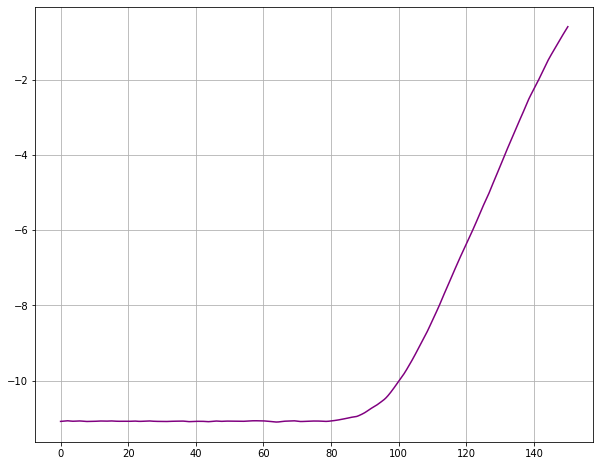

In [53]:
aver_ln_D = 0
t = [i * problem.discretization for i in range(int(problem.interval / problem.discretization))]
num_conditions = 100
for i in range(num_conditions):
    D_i = np.sqrt(((ans_pr_3[i] - ans_pr_3_p[i]) ** 2).sum(axis=0).sum(axis=1))
    aver_ln_D += np.log(np.sqrt(((ans_pr_3[i] - ans_pr_3_p[i]) ** 2).sum(axis=0).sum(axis=1))) / num_conditions
#     plt.plot(t, D_i)
fig = plt.figure(figsize=(10,8))
plt.plot(t, aver_ln_D, color='purple')
plt.grid()

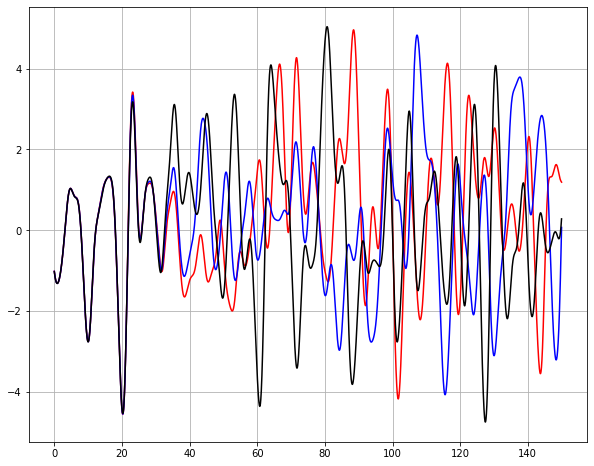

In [45]:
aver_M_2 = 0
for i in range(num_conditions):
    M_x = ans_pr_3[i].sum(axis=0)[:, 0]
    aver_M_2 += M_x / num_conditions
    t_2 = [i * problem.discretization for i in range(len(aver_M_2))]

    
fig = plt.figure(figsize=(10,8))
plt.plot(t, aver_M, color='r')
plt.plot(t_1, aver_M_1, color='b')
plt.plot(t_2, aver_M_2, color='k')
plt.grid()

# Ising

In [54]:
s = np.sqrt(3) / 2
slope = 1 / s / 20
num_conditions = 100

problem_Is = Shredinger_chain_spins()
problem_Is.num_objects = 11
problem_Is.J_z = 1
problem_Is.J_ort = 0
problem_Is.interval = 150
problem_Is.is_function_depends_on_x = True
s_0_x, s_0_y, s_0_z, s_0_x_p, s_0_y_p, s_0_z_p = generate_initial_conditions_random_with_perturbation(s, num_conditions * problem.num_objects)

In [55]:
problem_Is.discretization = 0.01
ans_pr_3_is = []
ans_pr_3_p_is = []
for state in tqdm(range(num_conditions)):
    problem_Is.initial_y = np.array([[s_0_x[state * problem_Is.num_objects + n], 
                                   s_0_y[state * problem_Is.num_objects + n],
                                   s_0_z[state * problem_Is.num_objects + n]]
                                  for n in range(problem_Is.num_objects)])
    ans_pr_3_is.append(problem_Is.run())
    problem_Is.initial_y = np.array([[s_0_x_p[state * problem_Is.num_objects + n], 
                                   s_0_y_p[state * problem_Is.num_objects + n],
                                   s_0_z_p[state * problem_Is.num_objects + n]]
                                  for n in range(problem_Is.num_objects)])
    ans_pr_3_p_is.append(problem_Is.run())

100%|██████████| 100/100 [38:48<00:00, 23.29s/it]


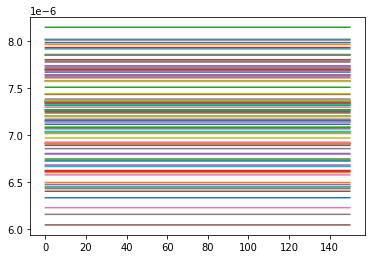

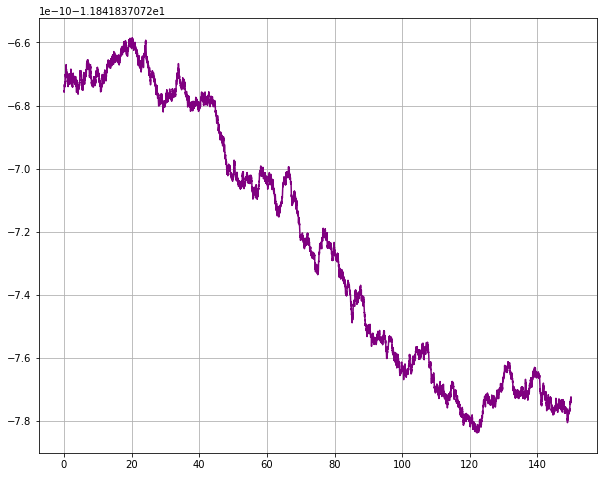

In [65]:
aver_ln_D_is = 0
t = [i * problem.discretization for i in range(int(problem_Is.interval / problem_Is.discretization))]
num_conditions = 100
for i in range(num_conditions):
    D_i_is = np.sqrt(((ans_pr_3_is[i] - ans_pr_3_p_is[i]) ** 2).sum(axis=0).sum(axis=1))
    aver_ln_D_is += np.log(D_i_is) / num_conditions
    plt.plot(t, D_i_is)
fig = plt.figure(figsize=(10,8))
plt.plot(t, aver_ln_D_is, color='purple')
plt.grid()

100%|██████████| 1/1 [00:13<00:00, 13.81s/it]


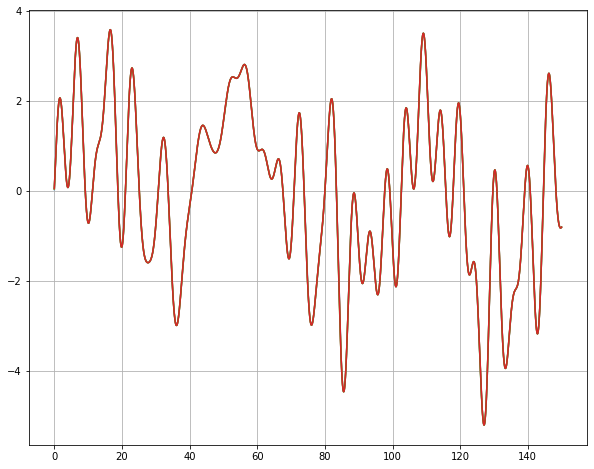

In [77]:
fig = plt.figure(figsize=(10,8))
for i in range(1, 5):
    num_conditions = 1
    problem_Is.discretization = 0.005 * i
    ans_pr_3_is = []
    ans_pr_3_p_is = []
    for state in tqdm(range(num_conditions)):
        problem_Is.initial_y = np.array([[s_0_x[state * problem_Is.num_objects + n], 
                                       s_0_y[state * problem_Is.num_objects + n],
                                       s_0_z[state * problem_Is.num_objects + n]]
                                      for n in range(problem_Is.num_objects)])
        ans_pr_3_is.append(problem_Is.run())
        aver_M = 0

    for i in range(num_conditions):
        M_x = ans_pr_3_is[i].sum(axis=0)[:, 0]
        aver_M += M_x / num_conditions
        t = [i * problem_Is.discretization for i in range(len(aver_M))]


    plt.plot(t, aver_M)

plt.grid()
#     problem_Is.initial_y = np.array([[s_0_x_p[state * problem_Is.num_objects + n], 
#                                    s_0_y_p[state * problem_Is.num_objects + n],
#                                    s_0_z_p[state * problem_Is.num_objects + n]]
#                                   for n in range(problem_Is.num_objects)])
#     ans_pr_3_p_is.append(problem_Is.run())

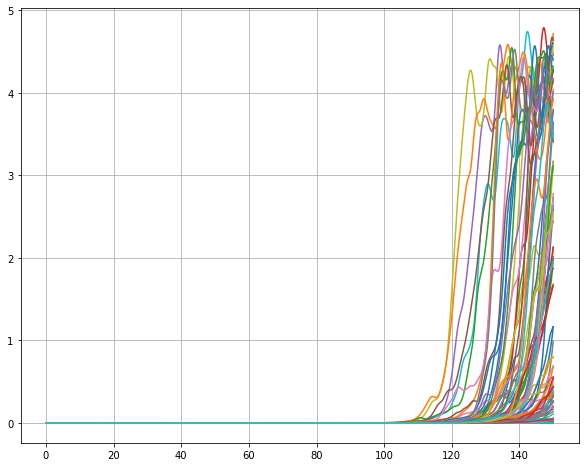

In [79]:
aver_ln_D = 0
t = [i * problem.discretization for i in range(int(problem.interval / problem.discretization))]
num_conditions = 100
fig = plt.figure(figsize=(10,8))
for i in range(num_conditions):
    D_i = np.sqrt(((ans_pr_3[i] - ans_pr_3_p[i]) ** 2).sum(axis=0).sum(axis=1))
    aver_ln_D += np.log(np.sqrt(((ans_pr_3[i] - ans_pr_3_p[i]) ** 2).sum(axis=0).sum(axis=1))) / num_conditions
    plt.plot(t, D_i)
# plt.plot(t, aver_ln_D, color='purple')
plt.grid()